In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update path for Kaggle environment)
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # adjust folder if needed
df = pd.read_csv(file_path)

# Clean column names to remove leading/trailing whitespace
df.columns = df.columns.str.strip()

# Ensure target column exists
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Stratified split: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Humanitarian_Class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Humanitarian_Class"], random_state=42)

# Save splits to CSV in current working directory (Kaggle/output folder is writable)
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
val_df.to_csv("/kaggle/working/val_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# Structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Humanitarian_Class"].value_counts(),
    "Validation (15%)": val_df["Humanitarian_Class"].value_counts(),
    "Test (15%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

# Save summary table
split_summary.to_csv("/kaggle/working/split_summary.csv")

# Print result
print("Data split completed and saved as CSV files in /kaggle/working.")



Data split completed and saved as CSV files in /kaggle/working.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
178/178 - 6s - 36ms/step - accuracy: 0.6255 - loss: 0.9443 - val_accuracy: 0.4104 - val_loss: 1.2441 - learning_rate: 0.0010
Epoch 2/20
178/178 - 1s - 3ms/step - accuracy: 0.8546 - loss: 0.4014 - val_accuracy: 0.6383 - val_loss: 0.9781 - learning_rate: 0.0010
Epoch 3/20
178/178 - 1s - 3ms/step - accuracy: 0.9129 - loss: 0.2429 - val_accuracy: 0.6766 - val_loss: 0.9079 - learning_rate: 0.0010
Epoch 4/20
178/178 - 1s - 3ms/step - accuracy: 0.9462 - loss: 0.1594 - val_accuracy: 0.6652 - val_loss: 1.1746 - learning_rate: 0.0010
Epoch 5/20
178/178 - 1s - 3ms/step - accuracy: 0.9635 - loss: 0.1119 - val_accuracy: 0.6685 - val_loss: 1.4094 - learning_rate: 0.0010
Epoch 6/20
178/178 - 1s - 3ms/step - accuracy: 0.9710 - loss: 0.0885 - val_accuracy: 0.6737 - val_loss: 1.5464 - learning_rate: 0.0010
Epoch 7/20
178/178 - 1s - 3ms/step - accuracy: 0.9809 - loss: 0.0570 - val_accuracy: 0.6704 - val_loss: 1.5413 - learning_rate: 2.0000e-04
Epoch 8/20
178/178 - 1s - 3ms/step - accuracy: 0.9

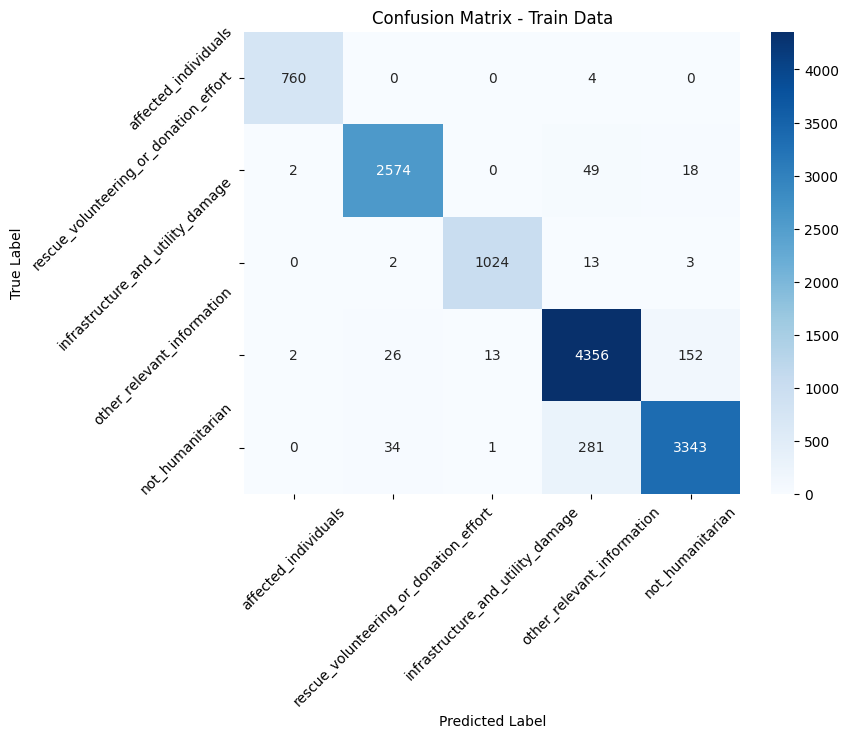

Model saved as 'tfidf_humanitarian_cnn_model.h5'


In [19]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# Load training data
train_df = pd.read_csv("/kaggle/working/train_data.csv")
val_df = pd.read_csv("/kaggle/working/val_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# Normalize column names
for df in [train_df, val_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()

# Label mapping
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# Preprocess labels
for df in [train_df, val_df, test_df]:
    df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

y_train = train_df['humanitarian_class'].map(label_map).astype(int)
y_val = val_df['humanitarian_class'].map(label_map).astype(int)
y_test = test_df['humanitarian_class'].map(label_map).astype(int)

# Fill missing text
for df in [train_df, val_df, test_df]:
    df['processed_data'] = df['processed_data'].fillna("")

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_text = vectorizer.fit_transform(train_df['processed_data'])
X_val_text = vectorizer.transform(val_df['processed_data'])
X_test_text = vectorizer.transform(test_df['processed_data'])

# Handcrafted features
for df in [train_df, val_df, test_df]:
    df['tweet_length'] = df['processed_data'].apply(len)
    df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
    df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_val_num = scaler.transform(val_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_test_num = scaler.transform(test_df[['tweet_length', 'num_hashtags', 'num_mentions']])

# Combine features
X_train_combined = np.hstack((X_train_text.toarray(), X_train_num))
X_val_combined = np.hstack((X_val_text.toarray(), X_val_num))
X_test_combined = np.hstack((X_test_text.toarray(), X_test_num))

# Apply SMOTE
max_class_samples = max(Counter(y_train).values())
sampling_strategy = {label: max_class_samples for label in np.unique(y_train)}
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# CNN-like Dense Model Definition
def create_dense_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Model
model = create_dense_model(X_train_resampled.shape[1], len(label_map))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=128, 
                    validation_data=(X_val_combined, y_val),
                    callbacks=[early_stopping, reduce_lr], verbose=2)

# Evaluate on Training Data
train_loss, train_acc = model.evaluate(X_train_combined, y_train)
print(f"Training Accuracy: {train_acc:.4f}")

# Predictions
y_pred_train = model.predict(X_train_combined)
y_pred_train = np.argmax(y_pred_train, axis=1)

# Classification Report
report_train = classification_report(y_train, y_pred_train, target_names=label_map.keys())
print("\nClassification Report (Train):\n", report_train)

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Train Data")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Save the model
model.save("tfidf_humanitarian_cnn_model.h5")
print("Model saved as 'tfidf_humanitarian_cnn_model.h5'")
